# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings

warnings.filterwarnings("ignore") #disable deprecation warnings

plt.style.use('fivethirtyeight') #styling option for how your plots will appear

# Import Data

In [2]:
path = r'/Users/docopeland/Documents/data analysis/career foundry/06 Open Data'

In [3]:
wdi = pd.read_pickle(os.path.join(path,'data','prepared data','wdi_short.pkl'))

# Transforming Data into a Time Series

In [4]:
#create an average labor force for each year
average = wdi.groupby(['year'])['labor force'].transform(np.mean)[:32]

In [5]:
#get all of the years without duplicates
years = wdi['year'].unique()

In [6]:
yea = [str(x)[:4] for x in years]

In [7]:
#create a df with year and average labor force
wdiTime = pd.DataFrame({'year':yea,'labor average':average})

In [8]:
#set the year to being a datetime column
wdiTime['year'] = pd.to_datetime(wdiTime['year'])

In [9]:
#set the year column to be the index
wdiTime = wdiTime.set_index('year')

In [10]:
wdiTime.head()

,labor average
year,
1990-01-01,48.885546
1991-01-01,49.050406
1992-01-01,49.213647
1993-01-01,49.305733
1994-01-01,49.497112


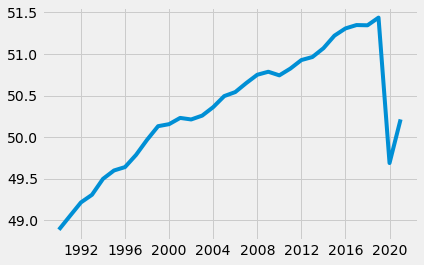

In [11]:
#quick plot of the data
plt.plot(wdiTime)

In [12]:
#check for nulls
wdiTime.isnull().sum()

labor average    0
dtype: int64

# Decomposition

In [13]:
#set the size of the graphs
from pylab import rcParams 
rcParams['figure.figsize'] = 18, 7

In [14]:
#decomp the df using the additive method
decomp = sm.tsa.seasonal_decompose(wdiTime, model = 'additive')

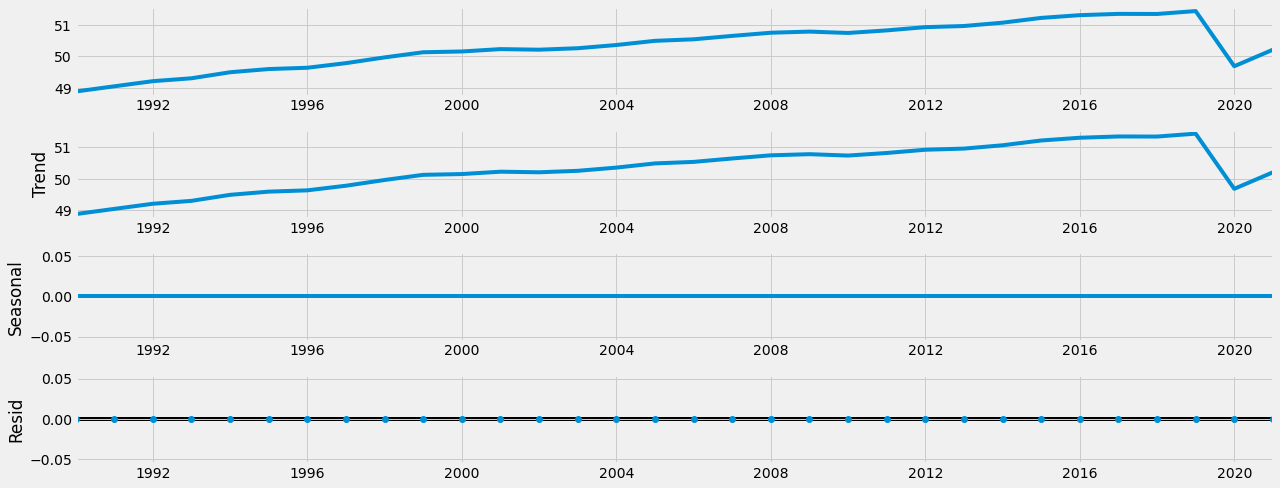

In [15]:
#show the decomposition
decomp.plot()
plt.show()

In [16]:
#there is definitely a trend and all of the data can be explained by this trend, there's nothing in seasonal, or resid
#so the timeseries must be non-stationary

# Checking for Stationality

In [17]:
#creating a function to show the results of the dickey fuller stationary test
from statsmodels.tsa.stattools import adfuller
def dickey_fuller(timeseries):
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)
dickey_fuller(wdiTime['labor average'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.203047
p-value                         0.205142
Number of Lags Used             0.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64


In [18]:
#i cannot disprove the null hyptohesis being that the data is non-stationary
#the p-value is 0.2 which is too high to disprove the null hypothesis (would want it t be less than 0.05)
#also the test statistic is bigger than all of the critical values
#will need to fix this

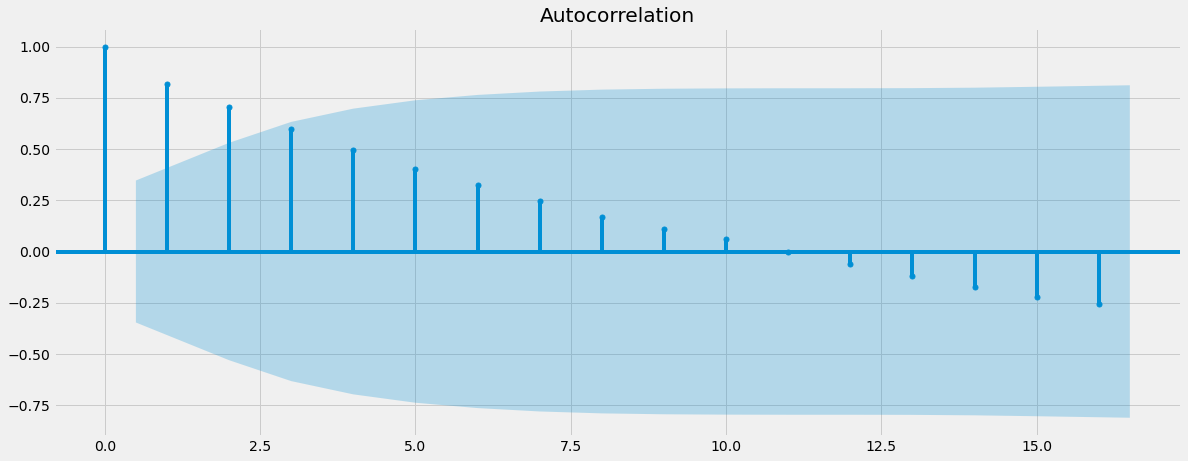

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(wdiTime)
plt.show()

In [20]:
#the 14/17 points within the confidence intervals, i can say that the timeseries is not autocorrelated

# Stationarizing

In [21]:
#doing differencing in order to make it stationary
wdiDiff = wdiTime - wdiTime.shift(1)

In [22]:
#drop any nans that come from the shit
wdiDiff.dropna(inplace = True)

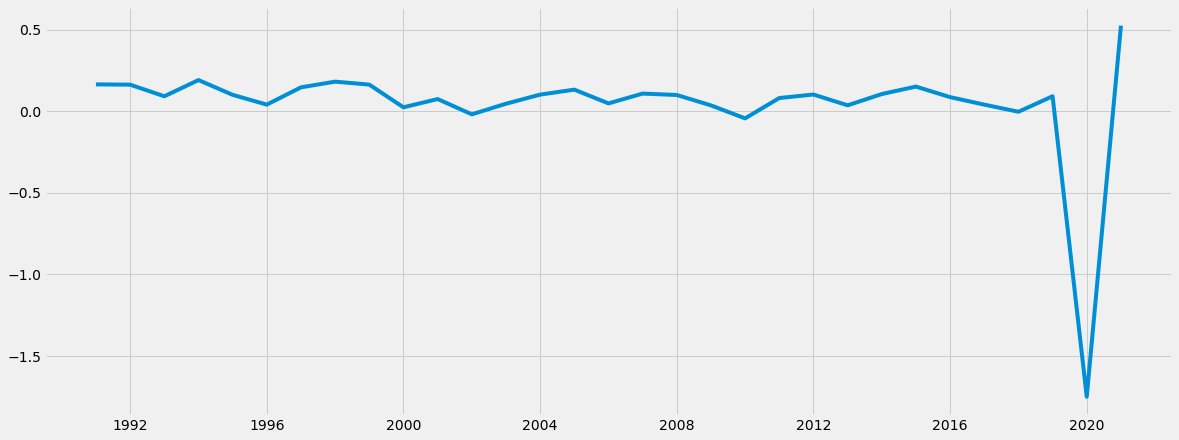

In [23]:
#plot the new timeseries
plt.plot(wdiDiff)
plt.show()

# Decomposing again

In [24]:
#doing a decomp on the new timeseries
decomp2 = sm.tsa.seasonal_decompose(wdiDiff,model = 'additive')

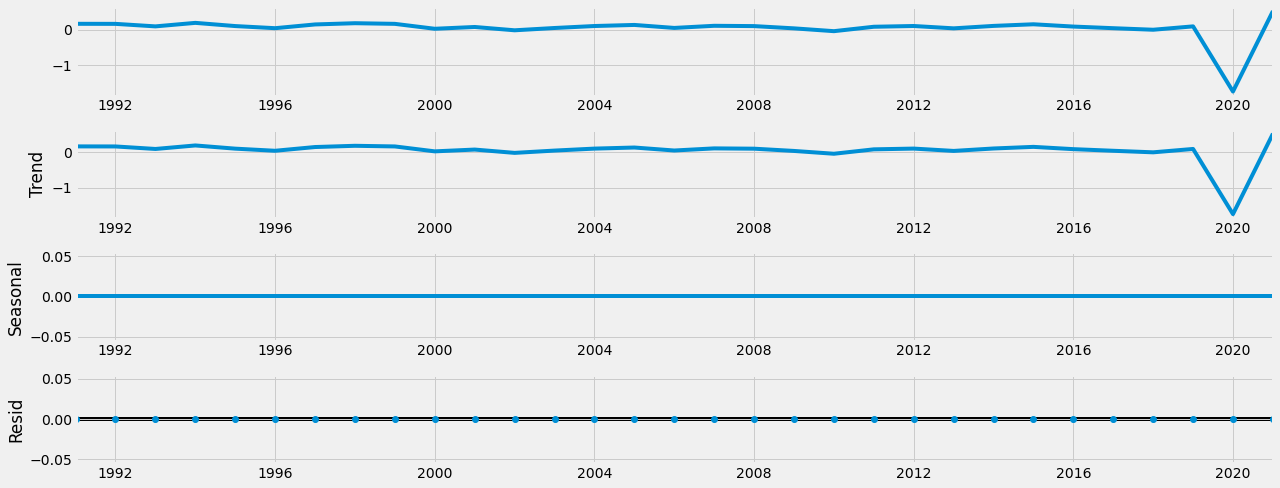

In [25]:
#plotting the decomp
decomp2.plot()
plt.show()

In [26]:
#again it looks like all of the graph is explained by the trend, I would say that this is non-stationary again
#but it's a lot better than the first time

# Checking for Stationality again

In [27]:
dickey_fuller(wdiDiff['labor average'])

Dickey-Fuller Stationarity test:
Test Statistic                -6.668676e+00
p-value                        4.647235e-09
Number of Lags Used            0.000000e+00
Number of Observations Used    3.000000e+01
Critical Value (1%)           -3.669920e+00
Critical Value (5%)           -2.964071e+00
Critical Value (10%)          -2.621171e+00
dtype: float64


In [28]:
#despite what i thought from the decompisition graph, it looks like the data is stationary now
#we can reject the null hypothesis of the timeseries being non-stationary
#the p-value is very small which is good
#also the test statistic is smaller than all of the critical values
#so we reject the null hypothesis with 99% confidence

# Autocorrelation

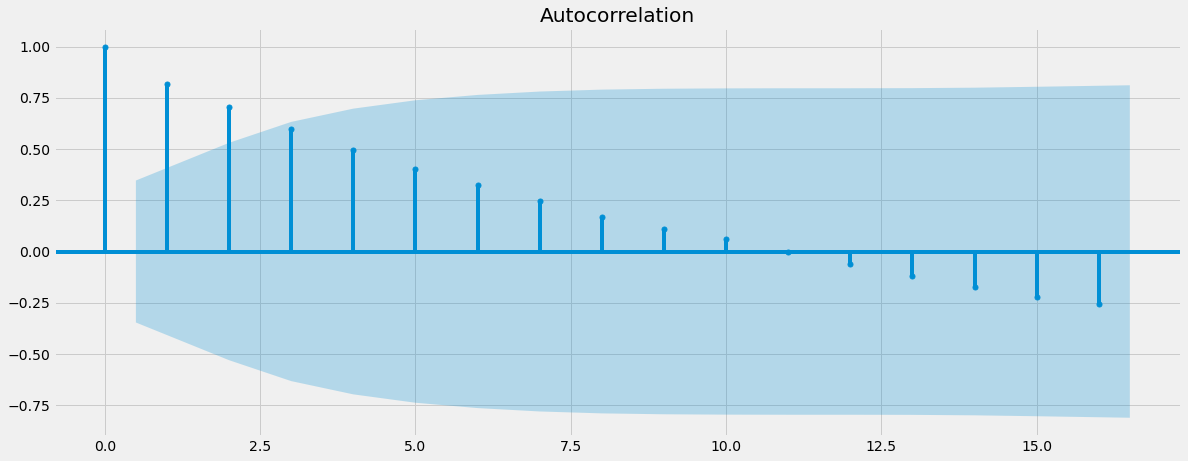

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(wdiTime)
plt.show()

In [30]:
#the timeseries is not autocorrelated as 13/16 lines are within the confidence interval